# MNIST Classification

华东师范大学 数学科学学院 陈久宁 2019年12月11日

！执行完后请务必记得重启或关闭kernel以释放GPU

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import torch
import torchvision

from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import math

## 一、数据读取

读取MNIST数据

* `torch.utils.data.Dataset` 负责数据的读取 -- lazy loading
* `torch.utils.data.DataLoader` 负责数据的载入 -- 并行计算

关于`Dataset`与`DataLoader`的设计思路，请回顾：http://ftp.lflab.cn/Courses/DeepLearning/Fall2019/Graduate/LectureMaterial/4.Dataset_loading.ipynb

In [3]:
train_data = torchvision.datasets.MNIST("data", train=True, download=True,
                                        transform=transforms.ToTensor())
valid_data = torchvision.datasets.MNIST("data", train=False, download=True,
                                        transform=transforms.ToTensor())

`Dataset`中定义了`__getindex__`下标读取的方法，因此`train_data[0]`可以正常工作

torch.Size([1, 28, 28])
5


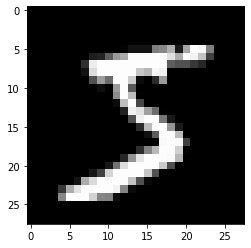

In [4]:
img, number = train_data[0]
print(img.shape)
print(number)
plt.imshow(img[0], cmap='gray')

DataLoader中定义了`__iter__`的迭代器方法，从而可以做如下操作:

* `for (X, Y) in train_data:` -- for循环会隐式构造迭代器
* `next(iter(train_data))` -- 通过`iter`显式构造迭代器

In [5]:
num_samples = len(train_data)
batch_size = 128
iter_per_epoch = math.ceil(num_samples/batch_size)
train_data = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [6]:
valid_data = DataLoader(valid_data, batch_size=len(valid_data))
valid_input, valid_label = next(iter(valid_data))

In [7]:
sample_input, sample_label = next(iter(train_data))

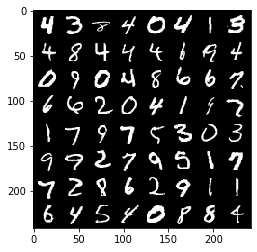

In [8]:
# Pytorch下图片是CHW格式，而matplotlib要求HW或HW3格式，因此需要permute
plt.imshow(torchvision.utils.make_grid(sample_input[0:64], nrow=8).permute(1, 2, 0))

## 二、定义网络结构

![](https://img-blog.csdn.net/20180829094603154?watermark/2/text/aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2NoZW55dXBpbmczMzM=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70)

因为GPU内存足够充裕，现在的实现一般不将通道进行拆分

In [9]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        # MNIST数据集的图片为28*28，因此需要调整网络尺寸
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) # x.view(-1)
        x = self.classifier(x)
        return x

## 训练网络

In [10]:
model = AlexNet(10).cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.CrossEntropyLoss()

In [11]:
valid_input, valid_label = valid_input.cuda(), valid_label.cuda()

In [12]:
epochs = 2
max_iters = iter_per_epoch * epochs

i = 0
train_loss_record = []
train_accuracy_record = []
valid_loss_record = []
valid_accuracy_record = []
for epoch in range(1, epochs+1):
    for X, Y in train_data:
        X, Y = X.cuda(), Y.cuda()
        
        opt.zero_grad()
        out = model(X)
        l = loss(out, Y)
        l.backward()
        opt.step()
    
        i += 1        
        if i%20==0 or i==max_iters:
            with torch.no_grad():
                pred_class = torch.max(out, 1)[1]
                train_accu = torch.sum(pred_class == Y).tolist()/float(len(Y))
                
                valid_pred = model(valid_input)
                valid_loss = loss(valid_pred, valid_label)
                pred_class = torch.max(valid_pred, 1)[1]
                valid_accu = torch.sum(pred_class == valid_label).tolist()/float(len(valid_label))
            
            train_loss_record.append(l.cpu().detach().numpy())
            train_accuracy_record.append(train_accu)
            valid_loss_record.append(valid_loss.cpu().detach().numpy())
            valid_accuracy_record.append(valid_accu)
            
            print(f"iter {i}/{max_iters} -- Loss: {l:.4f}, Accuracy: {train_accu*100:.2f}%, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accu*100:.2f}%")

iter 20/938 -- Loss: 2.2945, Accuracy: 12.50%, Valid Loss: 2.2954, Valid Accuracy: 15.70%
iter 40/938 -- Loss: 2.2325, Accuracy: 21.09%, Valid Loss: 2.2020, Valid Accuracy: 24.21%
iter 60/938 -- Loss: 1.4305, Accuracy: 51.56%, Valid Loss: 1.3397, Valid Accuracy: 56.25%
iter 80/938 -- Loss: 0.9469, Accuracy: 68.75%, Valid Loss: 0.8647, Valid Accuracy: 71.02%
iter 100/938 -- Loss: 0.7988, Accuracy: 72.66%, Valid Loss: 0.7446, Valid Accuracy: 75.68%
iter 120/938 -- Loss: 0.6745, Accuracy: 76.56%, Valid Loss: 0.5592, Valid Accuracy: 81.82%
iter 140/938 -- Loss: 0.6209, Accuracy: 78.91%, Valid Loss: 0.4902, Valid Accuracy: 84.05%
iter 160/938 -- Loss: 0.5085, Accuracy: 85.94%, Valid Loss: 0.3935, Valid Accuracy: 87.56%
iter 180/938 -- Loss: 0.3176, Accuracy: 92.19%, Valid Loss: 0.3236, Valid Accuracy: 90.01%
iter 200/938 -- Loss: 0.3456, Accuracy: 92.19%, Valid Loss: 0.3046, Valid Accuracy: 90.88%
iter 220/938 -- Loss: 0.2952, Accuracy: 92.97%, Valid Loss: 0.2614, Valid Accuracy: 91.60%
ite

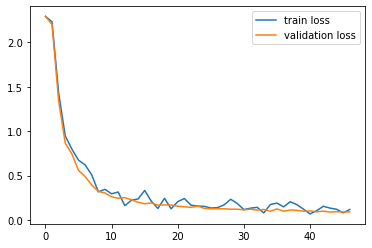

In [13]:
plt.plot(train_loss_record)
plt.plot(valid_loss_record)
plt.legend(["train loss", "validation loss"])

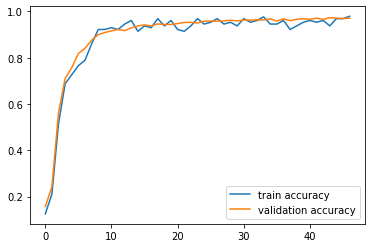

In [14]:
plt.plot(train_accuracy_record)
plt.plot(valid_accuracy_record)
plt.legend(["train accuracy", "validation accuracy"])